In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from experiments.configs.classification_consts import VALID_UQ_METHODS, VALID_ESTIMATORS, MODELS, DATASETS, SINGLE_CONFORMAL_METHODS
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,              # Use TeX for text rendering
    "font.family": "serif",
    "hatch.color": "white"
})
%load_ext autoreload
%autoreload 2

In [2]:

def convert_results_to_df(results_dict):
   
    df = pd.DataFrame.from_dict(
        {(dataset, method, hyperparam): metrics
        for dataset, methods in results_dict.items()
        for (method, hyperparam), metrics in methods.items()},
        orient='index'
    )

    # Convert index into MultiIndex
    df.index = pd.MultiIndex.from_tuples(df.index, names=['Dataset', 'Method', 'Estimator'])

    # Reset index to move 'Dataset' to a normal column
    df = df.reset_index()

    # Pivot table to reshape
    df = df.pivot(index="Dataset", columns=["Method", "Estimator"])

    # Fix column ordering
    df.columns = df.columns.reorder_levels([1, 2, 0])  # Move metric to last level
    df = df.sort_index(axis=1)  # Sort for readability
    return df

In [3]:
train_size = 0.8
#dataset_results = [pickle.load(open(f'../results/classification/aggregated_results/{dataset}_train_size_{train_size}_results.pkl', 'rb')) for dataset in DATASETS]
aggregated_results = pickle.load(open(f'../results/classification/aggregated_results/all_results_train_size_{train_size}.pkl', 'rb'))
df = convert_results_to_df(aggregated_results)
# Filter columns to only keep coverage_mean metric
df

Method          majority_vote                               \
Estimator                                                    
                coverage_mean coverage_std mean_width_mean   
Dataset                                                      
data_chess           0.977245     0.003120        7.367712   
data_cover_type      0.988800     0.002777       40.747950   
data_dionis          0.982150     0.003542      246.608883   
data_isolet          0.995321     0.002088        2.207949   
data_language        0.980000     0.008062       16.803000   
data_yeast           0.967340     0.005227        4.342761   

Method                                                                       \
Estimator                                                                     
                mean_width_scaled_mean mean_width_scaled_std mean_width_std   
Dataset                                                                       
data_chess                    0.409317              0.007909       0.142368   
data_cover_type               0.407479              0.018515       1.851462   
data_dionis                   0.694673              0.060655      21.532552   
data_isolet                   0.084921              0.003113       0.080931   
data_language                 0.560100              0.016931       0.507943   
data_yeast                    0.434276              0.011864       0.118639   

Method                                                      \
Estimator                                                    
                median_width_mean median_width_scaled_mean   
Dataset                                                      
data_chess                    7.0                 0.388889   
data_cover_type              41.8                 0.418000   
data_dionis                 306.3                 0.862817   
data_isolet                   1.6                 0.061538   
data_language                16.5                 0.550000   
data_yeast                    4.0                 0.400000   

Method                                                    ...  \
Estimator                                                 ...   
                median_width_scaled_std median_width_std  ...   
Dataset                                                   ...   
data_chess                     0.000000         0.000000  ...   
data_cover_type                0.021817         2.181742  ...   
data_dionis                    0.045194        16.044002  ...   
data_isolet                    0.018842         0.489898  ...   
data_language                  0.016667         0.500000  ...   
data_yeast                     0.000000         0.000000  ...   

Method          split_conformal_topk                               \
Estimator               RandomForest                                
                       coverage_mean coverage_std mean_width_mean   
Dataset                                                             
data_chess                  0.909462     0.004231        6.000000   
data_cover_type             0.901700     0.009039       10.901300   
data_dionis                 0.893400     0.003807       14.701933   
data_isolet                 0.924231     0.007855        1.000000   
data_language               0.912500     0.018337       11.400000   
data_yeast                  0.920202     0.015868        3.000000   

Method                                                                       \
Estimator                                                                     
                mean_width_scaled_mean mean_width_scaled_std mean_width_std   
Dataset                                                                       
data_chess                    0.333333          5.551115e-17       0.000000   
data_cover_type               0.109013          3.002676e-03       0.300268   
data_dionis                   0.041414          3.347250e-03       1.188274   
data_isolet                   0.038462          6.938894e-18       0.000

# Coverage  

In [4]:
df_coverage = df.loc[:, (slice(None), slice(None), ['coverage_mean','coverage_std'])]
df_coverage.to_latex(buf='classification_coverage.tex', index=False)

df_coverage.mean(axis=0)
# Split Conformal APS (HistGradientBoosting) does not achieve 90% coverage on average, so we exclude it from the analysis. 

Method                Estimator                          
majority_vote                               coverage_mean    0.981809
                                            coverage_std     0.004136
pcs_oob                                     coverage_mean    0.911413
                                            coverage_std     0.009517
split_conformal_aps   AdaBoost              coverage_mean    0.908801
                                            coverage_std     0.015582
                      ExtraTrees            coverage_mean    0.910394
                                            coverage_std     0.009052
                      HistGradientBoosting  coverage_mean    0.759295
                                            coverage_std     0.061963
                      LogisticRegression    coverage_mean    0.910060
                                            coverage_std     0.013350
                      MLP                   coverage_mean    0.893857
                                

In [5]:
df.loc[:, ('pcs_oob', slice(None), ['coverage_mean','coverage_std'])]
# PCS OOB achieves 90% for every dataset

Method                pcs_oob             
Estimator                                 
                coverage_mean coverage_std
Dataset                                   
data_chess           0.897343     0.005530
data_cover_type      0.896850     0.005697
data_dionis          0.904083     0.004543
data_isolet          0.960531     0.005773
data_language        0.909000     0.021656
data_yeast           0.900673     0.013903

In [6]:
df.loc[:, ('split_conformal_aps', ('RandomForest', 'HistGradientBoosting'), ['coverage_mean','coverage_std'])]
# Split Conformal APS (RF) achieves 90% coverage for every dataset but hist gradient boosting does not. 

Method          split_conformal_aps                                    \
Estimator              RandomForest              HistGradientBoosting   
                      coverage_mean coverage_std        coverage_mean   
Dataset                                                                 
data_chess                 0.899733     0.005141             0.899180   
data_cover_type            0.898150     0.007711             0.744350   
data_dionis                0.892467     0.005841             0.135100   
data_isolet                0.980449     0.003696             0.963590   
data_language              0.901500     0.016741             0.908500   
data_yeast                 0.896296     0.016273             0.905051   

Method                        
Estimator                     
                coverage_std  
Dataset                       
data_chess          0.004330  
data_cover_type     0.313835  
data_dionis         0.008856  
data_isolet         0.002935  
data_language       0.024602  
data_yeast          0.017221

In [8]:
df.loc[:, ('split_conformal_raps', ('RandomForest', 'HistGradientBoosting'), ['coverage_mean','coverage_std'])]
# Split Conformal RAPS (RF) achieves 90% coverage for every dataset but hist gradient boosting does not. 

Method          split_conformal_raps                                    \
Estimator               RandomForest              HistGradientBoosting   
                       coverage_mean coverage_std        coverage_mean   
Dataset                                                                  
data_chess                  0.900313     0.006406             0.897541   
data_cover_type             0.900250     0.009928             0.743800   
data_dionis                      NaN          NaN                  NaN   
data_isolet                 0.935064     0.020249             0.936923   
data_language               0.909500     0.017529             0.908000   
data_yeast                  0.901347     0.020317             0.899663   

Method                        
Estimator                     
                coverage_std  
Dataset                       
data_chess          0.003881  
data_cover_type     0.313436  
data_dionis              NaN  
data_isolet         0.007000  
data_language       0.026287  
data_yeast          0.012307

In [7]:
df.loc[:, ('split_conformal_topk', ('RandomForest'), ['coverage_mean','coverage_std'])]
# Split Conformal TopK (RF) achieves 90% coverage for every dataset

Method          split_conformal_topk             
Estimator               RandomForest             
                       coverage_mean coverage_std
Dataset                                          
data_chess                  0.909462     0.004231
data_cover_type             0.901700     0.009039
data_dionis                 0.893400     0.003807
data_isolet                 0.924231     0.007855
data_language               0.912500     0.018337
data_yeast                  0.920202     0.015868

In [8]:
df.loc[:, ('majority_vote', slice(None), ['coverage_mean','coverage_std'])]
# Majority Vote (HistGradientBoosting) achieves 90% coverage for every dataset


Method          majority_vote             
Estimator                                 
                coverage_mean coverage_std
Dataset                                   
data_chess           0.977245     0.003120
data_cover_type      0.988800     0.002777
data_dionis          0.982150     0.003542
data_isolet          0.995321     0.002088
data_language        0.980000     0.008062
data_yeast           0.967340     0.005227

In [39]:
methods_to_filter = ['split_conformal_raps', 'split_conformal_topk', 'split_conformal_aps']
split_conformal_df = df.copy()
split_conformal_df = split_conformal_df.loc[:, (slice(None), slice(None), ['coverage_mean'])]
split_conformal_df = split_conformal_df.loc[:, (['split_conformal_raps', 'split_conformal_topk', 'split_conformal_aps', 'majority_vote'], ['RandomForest'], slice(None))]
split_conformal_df
pcs_majority_df = df.copy()
pcs_majority_df = pcs_majority_df.loc[:, (slice(None), slice(None), ['coverage_mean'])]
pcs_majority_df = pcs_majority_df.loc[:, (['pcs_oob', 'majority_vote'], slice(None), slice(None))]
pcs_majority_df
df_coverage = pd.concat([split_conformal_df, pcs_majority_df], axis=1)
df_coverage = df_coverage.droplevel(level=1, axis=1).droplevel(level=1, axis=1)
df_coverage.to_latex(buf='classification_coverage.tex', index=True)


# Width 

In [9]:
df_width = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean','mean_width_scaled_std'])]

df_width.mean(axis=0)
# Best Estimator for each UQ_METHOD
# 1. Split Conformal APS (RF)
# 2. Split Conformal RAPS (RF)
# 3. Split Conformal TopK (RF)


Method                Estimator                                   
majority_vote                               mean_width_scaled_mean    0.431794
                                            mean_width_scaled_std     0.019831
pcs_oob                                     mean_width_scaled_mean    0.157099
                                            mean_width_scaled_std     0.003732
split_conformal_aps   AdaBoost              mean_width_scaled_mean    0.597861
                                            mean_width_scaled_std     0.085517
                      ExtraTrees            mean_width_scaled_mean    0.200232
                                            mean_width_scaled_std     0.006563
                      HistGradientBoosting  mean_width_scaled_mean    0.207922
                                            mean_width_scaled_std     0.019750
                      LogisticRegression    mean_width_scaled_mean    0.408491
                                            mean_width_scaled_st

# Plot Widths

In [12]:
# Filter to keep only RandomForest for the specified methods
methods_to_filter = ['split_conformal_raps', 'split_conformal_topk', 'split_conformal_aps']
split_conformal_df = df.copy()
split_conformal_df = split_conformal_df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean','mean_width_scaled_std'])]
split_conformal_df = split_conformal_df.loc[:, (['split_conformal_raps', 'split_conformal_topk', 'split_conformal_aps', 'majority_vote'], ['RandomForest'], slice(None))]
split_conformal_df
pcs_majority_df = df.copy()
pcs_majority_df = pcs_majority_df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean','mean_width_scaled_std'])]
pcs_majority_df = pcs_majority_df.loc[:, (['pcs_oob', 'majority_vote'], slice(None), slice(None))]
pcs_majority_df
df_best_widths = pd.concat([split_conformal_df, pcs_majority_df], axis=1)
df_best_widths

Method            split_conformal_raps                        \
Estimator                 RandomForest                         
                mean_width_scaled_mean mean_width_scaled_std   
Dataset                                                        
data_chess                    0.311570              0.010760   
data_cover_type               0.100172              0.010067   
data_dionis                        NaN                   NaN   
data_isolet                   0.074243              0.026708   
data_language                 0.380200              0.030307   
data_yeast                    0.268855              0.015065   

Method            split_conformal_topk                        \
Estimator                 RandomForest                         
                mean_width_scaled_mean mean_width_scaled_std   
Dataset                                                        
data_chess                    0.333333          5.551115e-17   
data_cover_type               0.109013          3.002676e-03   
data_dionis                   0.041414          3.347250e-03   
data_isolet                   0.038462          6.938894e-18   
data_language                 0.380000          1.632993e-02   
data_yeast                    0.300000          5.551115e-17   

Method             split_conformal_aps                        \
Estimator                 RandomForest                         
                mean_width_scaled_mean mean_width_scaled_std   
Dataset                                                        
data_chess                    0.305684              0.006378   
data_cover_type               0.094364              0.002399   
data_dionis                   0.036673              0.002307   
data_isolet                   0.145503              0.008484   
data_language                 0.355117              0.012606   
data_yeast                    0.278215              0.007751   

Method                         pcs_oob                        \
Estimator                                                      
                mean_width_scaled_mean mean_width_scaled_std   
Dataset                                                        
data_chess                    0.173818              0.001447   
data_cover_type               0.071264              0.000967   
data_dionis                   0.018820              0.001275   
data_isolet                   0.091628              0.002849   
data_language                 0.339217              0.011054   
data_yeast                    0.247845              0.004801   

Method                   majority_vote                        
Estimator                                                     
                mean_width_scaled_mean mean_width_scaled_std  
Dataset                                                       
data_chess                    0.409317              0.007909  
data_cover_type               0.407479              0.018515  
data_dionis                   0.694673              0.060655  
data_isolet                   0.084921              0.003113  
data_language                 0.560100              0.016931  
data_yeast                    0.434276              0.011864

In [1]:
legend_dict = {'majority_vote': 'Majority Vote', 'split_conformal_topk_RandomForest': 'TopK (Random Forest)', 'split_conformal_raps_RandomForest': 'RAPS (Random Forest)',
                'split_conformal_aps_RandomForest': 'APS (Random Forest)', 'pcs_oob': 'PCS'}
data_dict = {'data_chess': 'Chess', 'data_cover_type': 'Cover Type', 'data_dionis': 'Dionis', 'data_isolet': 'Isolet', 
             'data_language': 'Language', 'data_yeast': 'Yeast', 'data_walking': 'Walking'}
colors = {'PCS': 'orange', 'TopK (Random Forest)': '#697fa0', 'RAPS (Random Forest)': '#88CCEE', 'APS (Random Forest)': 'Blue', 'Majority Vote': '#86a76c'}
methods_to_plot = [
    #('pcs_uq', ''),
    ('pcs_oob', ''),
    ('split_conformal_topk', 'RandomForest'),
    ('majority_vote', ''),
    ('split_conformal_aps', 'RandomForest'),
    ('split_conformal_raps', 'RandomForest'),
]

# Set up transparency values
alpha_values = {}
for method, _ in methods_to_plot:
    if method == 'pcs_oob':
        alpha_values[method] = 1.0
    else:
        alpha_values[method] = 1.0
              
plt.figure(figsize=(30, 20), dpi=100)
# Add text next to each bar displaying % improve of PCS OOB over next best conformal method


# Get data for plotting
plot_data = []
plot_errors = []
labels = []
df_best_widths = df_best_widths.sort_values(by = ('pcs_oob','', 'mean_width_scaled_mean'), ascending=True)
df_plot = df_best_widths
for method, estimator in methods_to_plot:
    method_name = f"{method}_{estimator}" if estimator else method
    means = df_plot.loc[:, (method, estimator, 'mean_width_scaled_mean')].values
    stds = df_plot.loc[:, (method, estimator, 'mean_width_scaled_std')].values
    plot_data.append(means)
    plot_errors.append(stds)
    labels.append(legend_dict[method_name])

# Convert to numpy arrays
plot_data = np.array(plot_data)
plot_errors = np.array(plot_errors)

# Set up bar positions
n_methods = len(methods_to_plot)
n_datasets = len(df_plot.index)
width = 0.35  # Width of bars
x = np.arange(n_datasets)

# Create color palette
#colors = plt.cm.Set3(np.linspace(0, 1, n_methods))
# Increase spacing between x-ticks by adjusting figure size and/or x positions

# Increase spacing between x positions
x = np.arange(n_datasets) * 2.0 # Multiply by 1.5 to increase gaps between bars

# Plot bars
for i in range(n_methods):
    if i == 4:
        plt.bar(x[1:] + i*width - (n_methods-1)*width/2, 
            plot_data[i][1:],
            width,
            label=labels[i],
            yerr=plot_errors[i][1:],
            capsize=3,
            alpha=alpha_values[methods_to_plot[i][0]],
            color=colors[labels[i]])
    else:
        plt.bar(x + i*width - (n_methods-1)*width/2, 
            plot_data[i],
            width,
            label=labels[i],
            yerr=plot_errors[i],
            capsize=3,
            alpha=alpha_values[methods_to_plot[i][0]],
            color=colors[labels[i]])
# Customize plot
#plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Mean Scaled Width/ #Classes', fontsize=34)
#plt.yscale('log')
#plt.title('Prediction Interval Widths by Method and Dataset', fontsize=14, fontweight='bold', pad=20)

# Set x-axis ticks and labels
plt.xticks(x + 0.1, [data_dict[dataset] for dataset in df_plot.index], rotation=0, ha='center', fontsize=34)
plt.yticks(ticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=34)
plt.ylim(0.0,0.8)
# Add some style elements
#plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.legend(frameon=True, fancybox=True, shadow=True, loc = (-0.04,-0.09), fontsize=34, ncol=n_methods)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.savefig('figures/classification_widths.pdf', dpi=2000, bbox_inches='tight')


NameError: name 'plt' is not defined

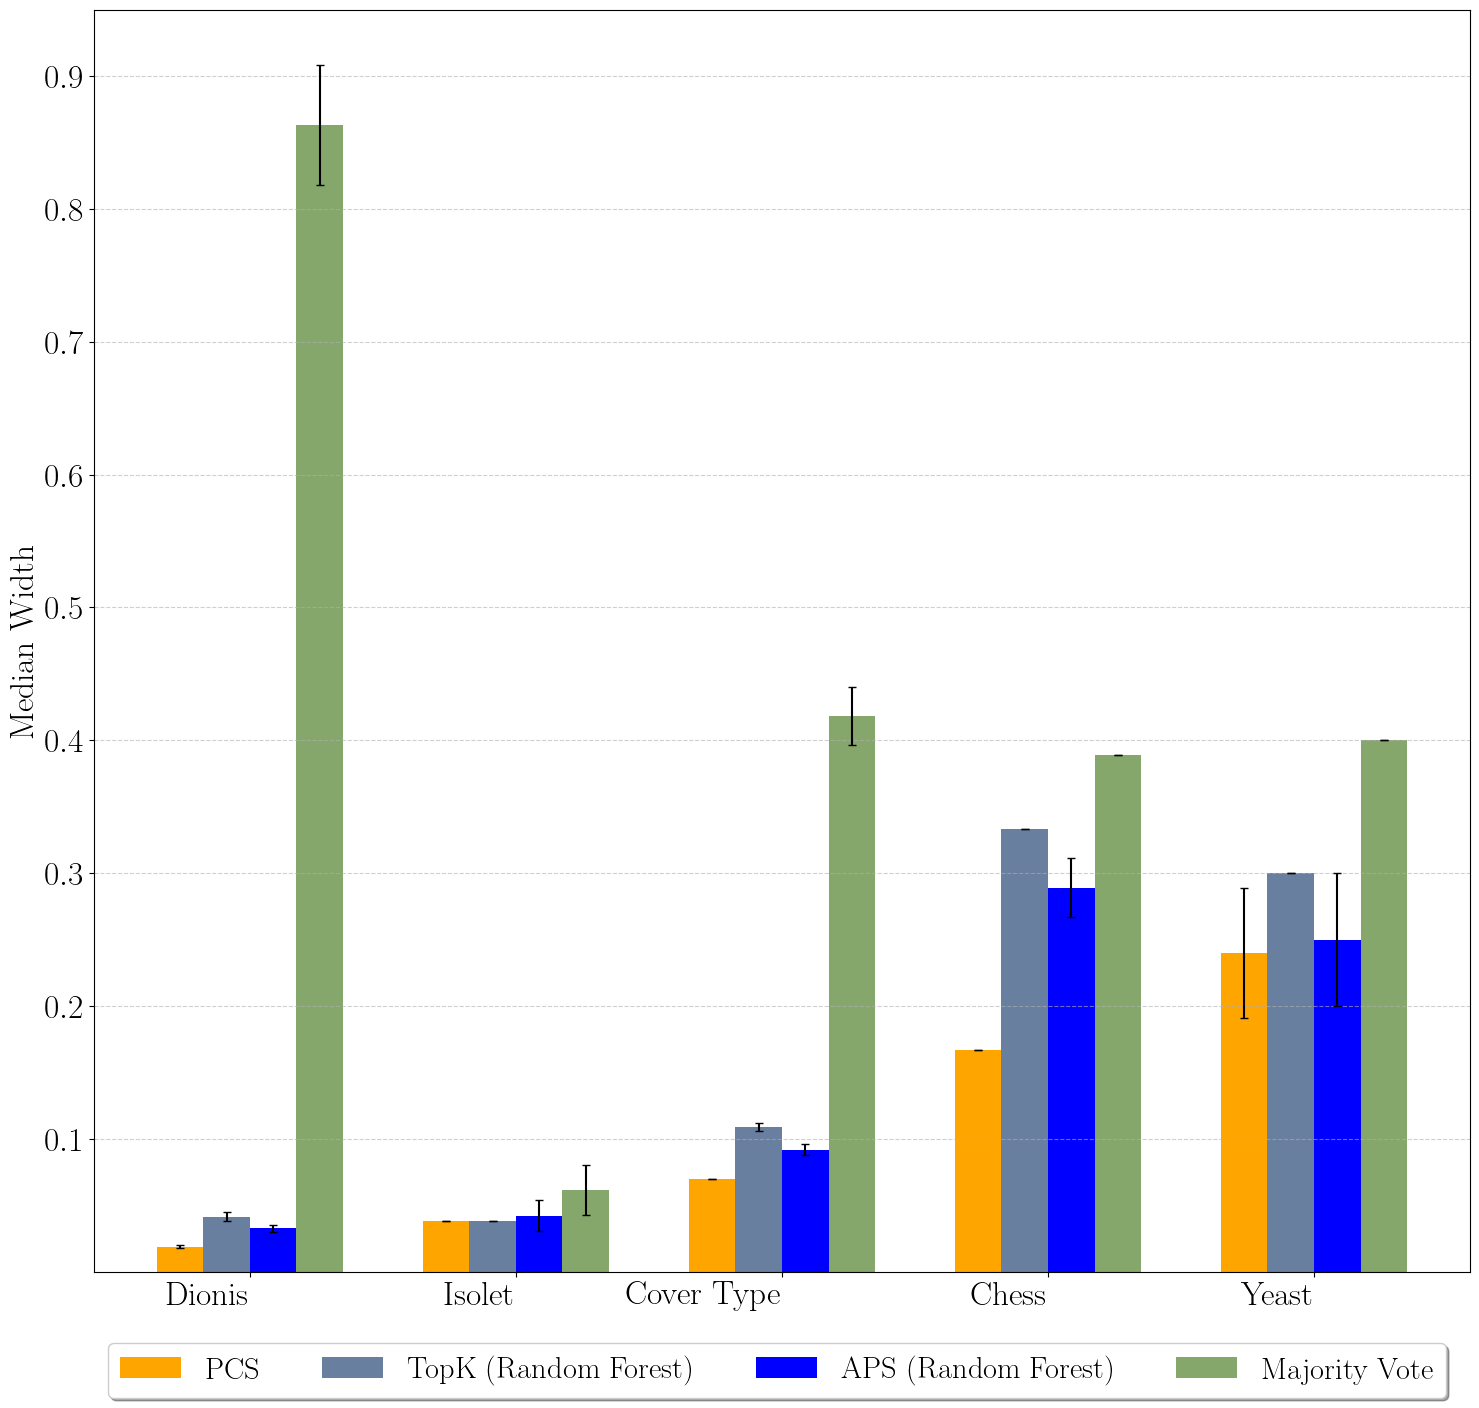

In [17]:
legend_dict = {'majority_vote': 'Majority Vote', 'split_conformal_topk_RandomForest': 'TopK (Random Forest)', 'split_conformal_raps_RandomForest': 'RAPS (Random Forest)',
                'split_conformal_aps_RandomForest': 'APS (Random Forest)', 'pcs_oob': 'PCS'}
data_dict = {'data_chess': 'Chess', 'data_cover_type': 'Cover Type', 'data_dionis': 'Dionis', 'data_isolet': 'Isolet', 
             'data_language': 'Language', 'data_yeast': 'Yeast', 'data_walking': 'Walking'}
colors = {'PCS': 'orange', 'TopK (Random Forest)': '#697fa0', 'RAPS (Random Forest)': 'red', 'APS (Random Forest)': 'Blue', 'Majority Vote': '#86a76c'}
methods_to_plot = [
    #('pcs_uq', ''),
    ('pcs_oob', ''),
    ('split_conformal_topk', 'RandomForest'),
    #('split_conformal_raps', 'RandomForest'),
    ('split_conformal_aps', 'RandomForest'),
    ('majority_vote', '')
]

# Set up transparency values
alpha_values = {}
for method, _ in methods_to_plot:
    if method == 'pcs_oob':
        alpha_values[method] = 1.0
    else:
        alpha_values[method] = 1.0
              
plt.figure(figsize=(16, 14), dpi=100)
# Add text next to each bar displaying % improve of PCS OOB over next best conformal method


# Get data for plotting
plot_data = []
plot_errors = []
labels = []
df = df.sort_values(by = ('pcs_oob','', 'median_width_scaled_mean'), ascending=True)
df_plot = df.iloc[:-1, :]
for method, estimator in methods_to_plot:
    method_name = f"{method}_{estimator}" if estimator else method
    means = df_plot.loc[:, (method, estimator, 'median_width_scaled_mean')].values
    stds = df_plot.loc[:, (method, estimator, 'median_width_scaled_std')].values
    plot_data.append(means)
    plot_errors.append(stds)
    labels.append(legend_dict[method_name])

# Convert to numpy arrays
plot_data = np.array(plot_data)
plot_errors = np.array(plot_errors)

# Set up bar positions
n_methods = len(methods_to_plot)
n_datasets = len(df_plot.index)
width = 0.35  # Width of bars
x = np.arange(n_datasets)

# Create color palette
#colors = plt.cm.Set3(np.linspace(0, 1, n_methods))
# Increase spacing between x-ticks by adjusting figure size and/or x positions

# Increase spacing between x positions
x = np.arange(n_datasets) * 2.0 # Multiply by 1.5 to increase gaps between bars

# Plot bars
for i in range(n_methods):
    plt.bar(x + i*width - (n_methods-1)*width/2, 
            plot_data[i], 
            width,
            label=labels[i],
            yerr=plot_errors[i],
            capsize=3,
            alpha=alpha_values[methods_to_plot[i][0]],
            color=colors[labels[i]])


# Customize plot
#plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Median Width', fontsize=24)
#plt.yscale('log')
#plt.title('Prediction Interval Widths by Method and Dataset', fontsize=14, fontweight='bold', pad=20)

# Set x-axis ticks and labels
plt.xticks(x, [data_dict[dataset] for dataset in df_plot.index], rotation=0, ha='right', fontsize=24)
plt.yticks(ticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=24)
plt.ylim(0.0,0.95)
# Add some style elements
#plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.legend(frameon=True, fancybox=True, shadow=True, loc = (0.01,-0.1), fontsize=22, ncol=4)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()